In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare data

In [2]:
data = pd.read_csv('../../../data/default_of_credit_card_clients_first_row_removed.csv')

## Drop NULL values
data = data.dropna()

## for dowhy

data['sex'] = np.where(data['sex'] == 2, 0,1)

non_numeric_columns = list(data.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    data[col] = le.fit_transform(data[col])

print(non_numeric_columns)

from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

## Reduce the data size to take a smaller sample

data = data.sample(5000)

protected_attribute = "sex"
print(data.head(5))

[]
             ID  LIMIT_BAL  sex  EDUCATION  MARRIAGE       AGE  PAY_0  PAY_2  \
3126   0.104203   0.090909  0.0   0.333333  0.666667  0.206897    0.4    0.4   
11357  0.378579   0.040404  0.0   0.333333  0.333333  0.310345    0.2    0.2   
9784   0.326144   0.070707  0.0   0.166667  0.666667  0.051724    0.2    0.2   
28094  0.936498   0.292929  0.0   0.500000  0.333333  0.431034    0.2    0.2   
1702   0.056735   0.141414  0.0   0.166667  0.666667  0.155172    0.2    0.2   

       PAY_3  PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
3126     0.2    0.2  ...   0.230753   0.156657   0.321172  0.000000  0.001781   
11357    0.2    0.2  ...   0.173424   0.094267   0.271973  0.001431  0.000772   
9784     0.2    0.2  ...   0.187079   0.109504   0.283218  0.004623  0.001899   
28094    0.2    0.1  ...   0.164039   0.082334   0.260979  0.011448  0.000000   
1702     0.4    0.2  ...   0.192776   0.104685   0.275840  0.011448  0.000012   

       PAY_AMT3  PAY_AMT4  PA

# Transform data using Reweighing

In [3]:
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.datasets import BinaryLabelDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2,random_state=0)

protected_attribute = "sex"
dataset = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)
dataset_orig_train, weights = dataset_transf.convert_to_dataframe()

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train,sample_weight=weights['instance_weights'])

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

,ID,LIMIT_BAL,sex,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Probability
3126,0.104203,0.090909,0.0,0.333333,0.666667,0.206897,0.4,0.4,0.2,0.2,...,0.230753,0.156657,0.321172,0.000000,0.001781,0.002232,0.003221,0.004689,0.003783,0.0
11357,0.378579,0.040404,0.0,0.333333,0.333333,0.310345,0.2,0.2,0.2,0.2,...,0.173424,0.094267,0.271973,0.001431,0.000772,0.001339,0.000000,0.001876,0.001135,0.0
9784,0.326144,0.070707,0.0,0.166667,0.666667,0.051724,0.2,0.2,0.2,0.2,...,0.187079,0.109504,0.283218,0.004623,0.001899,0.001020,0.001369,0.004818,0.015734,0.0


In [4]:
index = 0
df = dataset_orig_train.copy()
for i,row in df.iterrows():
    duplicate = round(weights["instance_weights"][int(index)])*10
    for j in range(int(duplicate)):
        df = df.append(row)
    index += 1
print(df.shape)

(55000, 25)


# Graph

In [5]:
causal_graph = """
digraph {
AGE;
sex;
MARRIAGE;
EDUCATION;
Probability;
U[label="Unobserved Confounders"];
sex -> Probability;
sex -> MARRIAGE; MARRIAGE -> Probability;
sex -> EDUCATION; EDUCATION -> Probability;
AGE -> EDUCATION; AGE -> MARRIAGE;
U->sex;U->Probability;
}
"""

## dowhy works for binary inputs only

df['Probability'] = np.where(df['Probability'] == 0, False, True)
df[protected_attribute] = np.where(df[protected_attribute] == 1, True, False)

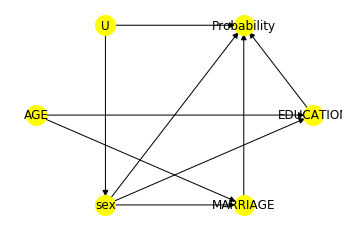

In [6]:
# With graph
model=CausalModel(
        data = df,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
──────(Expectation(Probability|AGE))
d[sex]                              
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,AGE,U) = P(Probability|sex,AGE)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [8]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
──────(Expectation(Probability|AGE))
d[sex]                              
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,AGE,U) = P(Probability|sex,AGE)

## Realized estimand
b: Probability~sex+AGE
Target units: ate

## Estimate
Mean value: 0.03254705168071326

Causal Estimate is 0.03254705168071326


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [9]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.03254705168071326
New effect:0.03243170994006415



# Replace Treatment with Placebo

In [10]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.03254705168071326
New effect:-6.651694135184037e-06
p value:0.5



# Remove Random Subset of Data

In [11]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.03254705168071326
New effect:0.03223085069613568
p value:0.43000000000000005

